In [1]:

import math

def too_naive_softmax(x):
    max_mem = max(x)
    result = [math.e**(xi-max_mem) for xi in x]
    sum_all = sum(result)
    for i in range(len(x)):
        result[i] = result[i]/sum_all
    return result

In [2]:
x = [1000, 999, 998]
too_naive_softmax(x)

[0.6652409557748218, 0.24472847105479764, 0.09003057317038046]

In [3]:
import torch
def naive_softmax(x):
    M, N = x.shape
    # read MN elements, write M elements
    max_mem = torch.max(x, dim=-1).values
    # read MN + M elements, write MN elements
    z = x - max_mem.unsqueeze(-1).expand(M, N)
    # read MN elements, write MN elements
    z = torch.exp(z)
    # read MN elements, write M elements
    row_sum = torch.sum(z,-1).unsqueeze(-1).expand(M, N)
    # read MN + M elements, write MN elements
    result = z/row_sum
    # Total:: Read: 5MN + 2M; Write: 3MN+2M
    return result
    

In [4]:

x = torch.tensor([[2.0,1.0,0.1],[1000, 999, 998]])
naive_softmax(x)

tensor([[0.6590, 0.2424, 0.0986],
        [0.6652, 0.2447, 0.0900]])

In [5]:
import triton
import triton.language as tl
from triton.runtime import driver

DEVICE = triton.runtime.driver.active.get_active_torch_device()

def is_hip():
    return triton.runtime.driver.active.get_current_target().backend == "hip"


def is_cdna():
    return is_hip() and triton.runtime.driver.active.get_current_target().arch in ('gfx940', 'gfx941', 'gfx942',
                                                                                   'gfx90a', 'gfx908')


@triton.jit
def softmax_kernel(output_ptr, input_ptr, input_row_stride, output_row_stride, n_rows, n_cols, BLOCK_SIZE: tl.constexpr):
    # tl.device_print("BLOCK_SIZE", BLOCK_SIZE)
    pid = tl.program_id(0)
    row_start_ptr = input_ptr + pid * input_row_stride
    col_offsets = tl.arange(0, BLOCK_SIZE)
    input_ptrs = row_start_ptr + col_offsets
    # Load the row data into a block. Use a mask for rows shorter than BLOCK_SIZE.
    mask = col_offsets < n_cols
    row = tl.load(input_ptrs, mask=mask, other=-float('inf'))
    row_max = tl.max(row, axis=0)
    numerator = tl.exp(row - row_max)
    denominator = tl.sum(numerator, axis=0)
    output = numerator / denominator
    
    # Store the result back to global memory.
    output_ptrs = output_ptr + pid * output_row_stride + col_offsets
    tl.store(output_ptrs, output, mask=mask)

In [6]:
def triton_softmax(x: torch.Tensor):
    if not x.is_cuda:
        x = x.cuda()

    n_rows, n_cols = x.shape
    output = torch.empty_like(x)
    grid = (n_rows,)

    softmax_kernel[grid](
        output_ptr=output, 
        input_ptr=x, 
        input_row_stride=x.stride(0),
        output_row_stride=output.stride(0),
        n_rows=n_rows,
        n_cols=n_cols,
        BLOCK_SIZE=triton.next_power_of_2(n_cols)
    )
    
    return output

In [7]:
x = torch.tensor([[2.0,1.0,0.1],[1000, 999, 998]], device=DEVICE)
triton_softmax(x)

tensor([[0.6590, 0.2424, 0.0986],
        [0.6652, 0.2447, 0.0900]], device='cuda:0')

In [8]:
import os
import torch
from torch.utils.cpp_extension import load

# this_dir = os.path.dirname(__file__)

this_dir = os.getcwd()
ext = load(
  name="softmax_ext",
  sources=[
    os.path.join(this_dir, "softmax.cpp"),
    os.path.join(this_dir, "softmax_kernel.cu"),
  ],
  verbose=True,
)

def cuda_softmax(x: torch.Tensor):
  return ext.softmax_cuda(x)

x = torch.tensor([[2.0,1.0,0.1],[1000, 999, 998]], device=DEVICE)
cuda_softmax(x)

ninja: no work to do.


tensor([[0.6590, 0.2424, 0.0986],
        [0.6652, 0.2447, 0.0900]], device='cuda:0')

In [9]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        # X-axis configuration: the independent variable we're testing
        x_names=['N'],  # Parameter name that varies across benchmark runs
        x_vals=[128*i for i in range(10, 351, 20)],  # Test sizes from 2^8 (256) to 2^27 (134M) elements
        # x_log=True,  # Use logarithmic scale for x-axis (better for exponential ranges)

        # Line configuration: compare different implementations
        line_arg='provider',  # Parameter that distinguishes different implementations
        # line_vals=['triton', 'torch', 'naive'],  # Internal identifiers for each implementation
        line_vals=['triton', 'torch', 'naive', 'cuda_softmax'],  # Internal identifiers for each implementation
        # line_names=['Triton', 'Torch', 'naive'],  # Display names for the legend
        line_names=['Triton', 'Torch', 'naive', 'cuda_softmax'],  # Display names for the legend
        styles=[('blue', '-'), ('green', '-'), ('red', '-'),  ('black', '-.')],  # (color, line_style) tuples

        # Plot configuration
        ylabel='GB/s',  # Y-axis label (measuring memory bandwidth)
        plot_name='softmax-performance',  # Output filename and plot title
        args={'M': 256},  # Additional fixed arguments (empty here since we only vary size/provider)
    ))
    # basically, the above decorator says that I'm going to have a 2D Diagram
    # x values would be 'size' and lines would be triton, torch and cuda.
def benchmark(M, N, provider):
    """
    Benchmarks vector addition across three implementations: PyTorch, Triton, and CUDA.

    Args:
        size: Number of elements in the vectors
        provider: Which implementation to benchmark ('torch', 'triton', or 'cuda')

    Returns:
        Tuple of (median_gbps, min_gbps, max_gbps) representing bandwidth at different quantiles
    """
    # Create random input tensors on the specified device
    x = torch.randn(M, N, device=DEVICE, dtype=torch.float32)

    for _ in range(5):
        if provider == 'torch':
            torch.softmax(x, axis=-1)
        elif provider == 'triton':
            triton_softmax(x)
        else:
            naive_softmax(x)
    torch.cuda.synchronize()
    # Quantiles for statistical analysis: [median, 20th percentile, 80th percentile]
    # This captures the distribution of timings across multiple runs
    quantiles = [0.5, 0.2, 0.8]

    # Benchmark each implementation
    # do_bench runs the lambda multiple times and returns timing statistics
    stream = getattr(torch, DEVICE.type).Stream()
    getattr(torch, DEVICE.type).set_stream(stream)
    if provider == 'torch':
        # Native PyTorch element-wise addition
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.softmax(x, axis=-1), quantiles=quantiles)
    if provider == 'triton':
        # Custom Triton kernel implementation
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: triton_softmax(x), quantiles=quantiles)
    if provider == 'naive':
        # Custom CUDA kernel implementation
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: naive_softmax(x), quantiles=quantiles)
    if provider == 'cuda_softmax':
        # Custom CUDA kernel implementation
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: cuda_softmax(x), quantiles=quantiles)

    # Calculate memory bandwidth in GB/s
    # Formula breakdown:
    #   - 3 * x.numel(): total elements accessed (read x, read y, write output)
    #   - x.element_size(): bytes per element (4 bytes for float32)
    #   - 1e-9: convert bytes to gigabytes
    #   - (ms * 1e-3): convert milliseconds to seconds
    gbps = lambda ms: 2 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)

    # Return bandwidth for median, fastest (max_ms → min bandwidth), and slowest (min_ms → max bandwidth)
    # Note: max_ms gives min bandwidth and vice versa
    return gbps(ms), gbps(max_ms), gbps(min_ms)

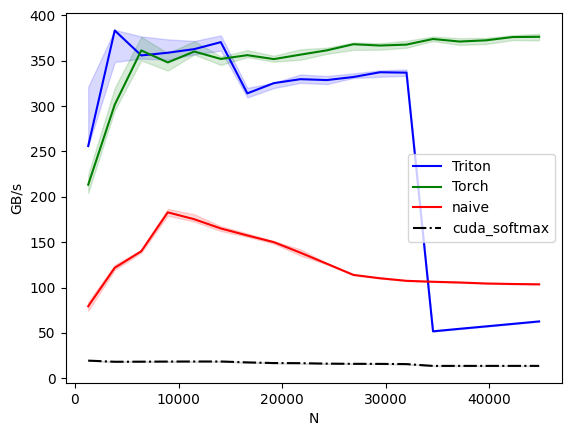

softmax-performance:
          N      Triton       Torch       naive  cuda_softmax
0    1280.0  256.000006  213.333326   79.303005     19.393939
1    3840.0  383.400941  301.546021  121.723625     18.137269
2    6400.0  355.864455  361.358619  139.938507     18.233618
3    8960.0  358.848573  348.172441  182.857149     18.360656
4   11520.0  362.834627  360.175869  175.292444     18.432000
5   14080.0  370.526332  352.000009  165.100766     18.441765
6   16640.0  314.054853  356.173919  157.398762     17.446777
7   19200.0  325.337579  351.839651  150.000000     16.717457
8   21760.0  329.696967  356.721318  138.405887     16.598808
9   24320.0  328.718059  361.509691  126.184033     16.064486
10  26880.0  332.108117  368.219164  113.890766     15.857092
11  29440.0  337.330586  366.782185  110.204129     15.793991
12  32000.0  336.897519  367.816090  107.376919     15.583150
13  34560.0   51.697829  374.000685  106.343575     13.558258
14  37120.0   54.473081  371.200009  105.555286  

In [10]:
benchmark.run(show_plots=True, print_data=True)

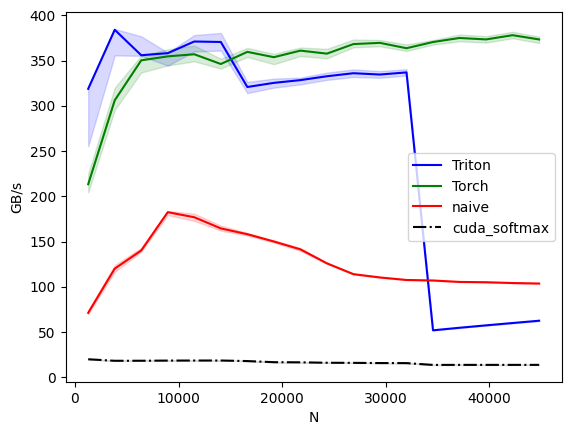

softmax-performance:
          N      Triton       Torch       naive  cuda_softmax
0    1280.0  318.754855  213.333326   71.111109     19.844962
1    3840.0  384.000010  306.052303  120.000000     18.156029
2    6400.0  355.864455  350.235143  140.082084     18.207681
3    8960.0  358.176147  354.632041  182.391860     18.377720
4   11520.0  371.051838  356.949909  176.805752     18.439145
5   14080.0  370.526332  346.185167  164.467967     18.458954
6   16640.0  320.771094  359.601557  158.052833     17.849588
7   19200.0  325.337579  353.713308  150.000000     16.616184
8   21760.0  328.375389  360.974594  141.313035     16.469350
9   24320.0  332.652276  357.647053  125.867706     15.977745
10  26880.0  336.000008  368.219164  113.898302     15.860674
11  29440.0  334.545452  369.551825  110.255720     15.651444
12  32000.0  336.897519  363.636361  107.478355     15.586946
13  34560.0   51.843239  370.492473  106.919317     13.590164
14  37120.0   54.668631  374.949506  105.309632  

In [11]:
benchmark.run(show_plots=True, print_data=True)